In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from glob import glob
from tqdm import tqdm
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

In [11]:
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def extract_angles(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)
    if not results.pose_landmarks:
        return None
    lm = results.pose_landmarks.landmark
    def pt(idx):
        return [lm[idx].x, lm[idx].y]
    try:
        return {
            'left_knee': calculate_angle(pt(mp_pose.PoseLandmark.LEFT_HIP),
                                        pt(mp_pose.PoseLandmark.LEFT_KNEE),
                                        pt(mp_pose.PoseLandmark.LEFT_ANKLE)),
            'right_knee': calculate_angle(pt(mp_pose.PoseLandmark.RIGHT_HIP),
                                         pt(mp_pose.PoseLandmark.RIGHT_KNEE),
                                         pt(mp_pose.PoseLandmark.RIGHT_ANKLE)),
            'left_shoulder': calculate_angle(pt(mp_pose.PoseLandmark.LEFT_ELBOW),
                                            pt(mp_pose.PoseLandmark.LEFT_SHOULDER),
                                            pt(mp_pose.PoseLandmark.LEFT_HIP)),
            'right_shoulder': calculate_angle(pt(mp_pose.PoseLandmark.RIGHT_HIP),
                                             pt(mp_pose.PoseLandmark.RIGHT_SHOULDER),
                                             pt(mp_pose.PoseLandmark.RIGHT_ELBOW))
        }
    except:
        return None

In [12]:
BASE_DIR = "tree_pose"
reference = {}
steps = [f"step{i}" for i in range(1, 6)]

print("🔍 Learning ideal poses from reference images...\n")

for step in steps:
    folder = os.path.join(BASE_DIR, step)
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"Folder missing: {folder}")
    
    img_paths = sorted(glob(os.path.join(folder, "*.jpg")) + 
                      glob(os.path.join(folder, "*.png")))
    if not img_paths:
        raise ValueError(f"No images in {folder}")
    
    all_angles = []
    for path in tqdm(img_paths, desc=f"Processing {step}"):
        angles = extract_angles(path)
        if angles:
            all_angles.append(angles)
    
    if not all_angles:
        raise RuntimeError(f"Failed to extract poses from {step}")
    
    df = pd.DataFrame(all_angles)
    ref_mean = df.mean().to_dict()
    ref_std = df.std().to_dict()
    reference[step] = {'mean': ref_mean, 'std': ref_std, 'n_images': len(all_angles)}
    
    print(f"\n{step.upper()} (based on {len(all_angles)} images):")
    for joint in ref_mean:
        print(f"  {joint.replace('_', ' ').title()}: {ref_mean[joint]:.1f}° ± {ref_std[joint]:.1f}°")

with open('tree_pose_reference.json', 'w') as f:
    json.dump({
        step: {
            'mean': {k: float(v) for k, v in data['mean'].items()},
            'std': {k: float(v) for k, v in data['std'].items()},
            'n_images': data['n_images']
        }
        for step, data in reference.items()
    }, f, indent=2)

print("\n✅ Reference templates saved to 'tree_pose_reference.json'")

🔍 Learning ideal poses from reference images...



Processing step1: 100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.46it/s]



STEP1 (based on 7 images):
  Left Knee: 176.6° ± 3.0°
  Right Knee: 176.8° ± 2.3°
  Left Shoulder: 27.7° ± 8.3°
  Right Shoulder: 25.8° ± 7.3°


Processing step2: 100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.37it/s]



STEP2 (based on 7 images):
  Left Knee: 150.3° ± 58.4°
  Right Knee: 43.0° ± 58.3°
  Left Shoulder: 47.5° ± 14.2°
  Right Shoulder: 26.6° ± 18.4°


Processing step3: 100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.48it/s]



STEP3 (based on 7 images):
  Left Knee: 154.7° ± 56.6°
  Right Knee: 45.7° ± 58.7°
  Left Shoulder: 170.2° ± 4.7°
  Right Shoulder: 170.2° ± 10.8°


Processing step4: 100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.16it/s]



STEP4 (based on 7 images):
  Left Knee: 150.3° ± 58.4°
  Right Knee: 43.0° ± 58.3°
  Left Shoulder: 47.5° ± 14.2°
  Right Shoulder: 26.6° ± 18.4°


Processing step5: 100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.92it/s]


STEP5 (based on 7 images):
  Left Knee: 176.6° ± 3.0°
  Right Knee: 176.8° ± 2.3°
  Left Shoulder: 27.7° ± 8.3°
  Right Shoulder: 25.8° ± 7.3°

✅ Reference templates saved to 'tree_pose_reference.json'


In [13]:
def evaluate_sequence(user_img_paths, tolerance_deg=10.0):
    if len(user_img_paths) != 5:
        raise ValueError("Provide exactly 5 images (one per step)")
    
    per_step = []
    details = []
    
    for i, img_path in enumerate(user_img_paths):
        step_key = f"step{i+1}"
        user_angles = extract_angles(img_path)
        
        if user_angles is None:
            acc = 0.0
        else:
            ref_angles = reference[step_key]['mean']
            joint_accuracies = []
            for joint in ref_angles:
                if joint in user_angles:
                    ref_val = ref_angles[joint]
                    user_val = user_angles[joint]
                    error = abs(user_val - ref_val)
                    # Use fixed degree tolerance (e.g., ±10°)
                    if error <= tolerance_deg:
                        joint_acc = 100.0
                    else:
                        # Optionally scale down, or just 0
                        joint_acc = max(0.0, 100.0 * (1.0 - (error - tolerance_deg) / 30.0))
                    joint_accuracies.append(joint_acc)
                else:
                    joint_accuracies.append(0.0)
            acc = np.mean(joint_accuracies)
        
        per_step.append(acc)
        details.append({'step': step_key, 'accuracy': acc})
    
    return {
        'per_step_accuracy': per_step,
        'overall_accuracy': np.mean(per_step),
        'details': details
    }

In [14]:
USER_SEQUENCE = [
    "tree_pose/step1/001.jpg",
    "tree_pose/step2/001.png",
    "tree_pose/step3/001.jpg",
    "tree_pose/step4/001.png",
    "tree_pose/step5/001.jpg"
]

result = evaluate_sequence(USER_SEQUENCE, tolerance_deg=10.0)

print("🎯 TREE POSE SEQUENCE EVALUATION RESULTS\n")
print(f"Overall Flow Accuracy: {result['overall_accuracy']:.1f}%\n")

for i, acc in enumerate(result['per_step_accuracy']):
    status = "✅ Good" if acc >= 80 else "⚠️ Fair" if acc >= 60 else "❌ Poor"
    print(f"Step {i+1}: {acc:.1f}%  →  {status}")

print("\n📝 Interpretation:")
print("- Accuracy = how closely your pose matches the ideal (±10% tolerance)")
print("- Green (✅) = ≥80%, Yellow (⚠️) = 60–79%, Red (❌) = <60%")

🎯 TREE POSE SEQUENCE EVALUATION RESULTS

Overall Flow Accuracy: 89.9%

Step 1: 93.6%  →  ✅ Good
Step 2: 89.1%  →  ✅ Good
Step 3: 84.1%  →  ✅ Good
Step 4: 89.1%  →  ✅ Good
Step 5: 93.6%  →  ✅ Good

📝 Interpretation:
- Accuracy = how closely your pose matches the ideal (±10% tolerance)
- Green (✅) = ≥80%, Yellow (⚠️) = 60–79%, Red (❌) = <60%


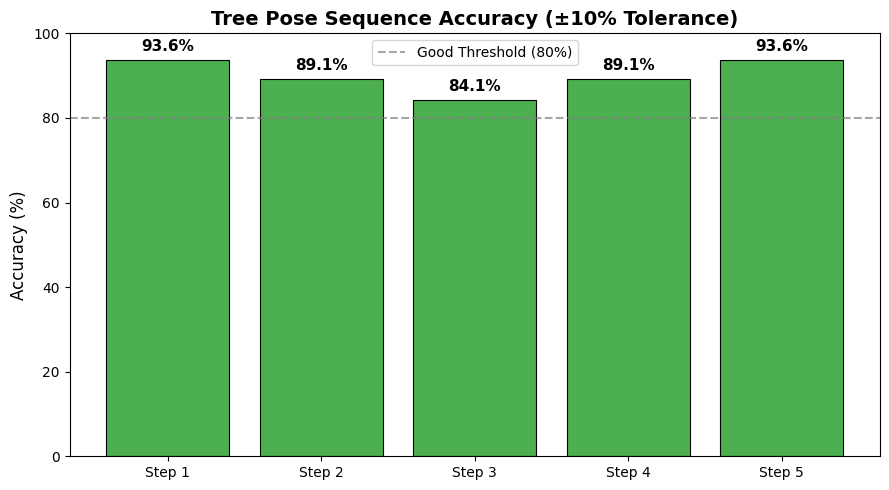

In [15]:
steps = [f"Step {i+1}" for i in range(5)]
accs = result['per_step_accuracy']

plt.figure(figsize=(9, 5))
colors = ['#4CAF50' if a >= 80 else '#FF9800' if a >= 60 else '#F44336' for a in accs]
bars = plt.bar(steps, accs, color=colors, edgecolor='black', linewidth=0.8)

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Tree Pose Sequence Accuracy (±10% Tolerance)', fontsize=14, fontweight='bold')
plt.axhline(y=80, color='gray', linestyle='--', alpha=0.7, label='Good Threshold (80%)')
plt.legend()

for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()